<a href="https://colab.research.google.com/github/samehaisaa/streamlit-groq-langchainLLM/blob/main/Tangent_Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geomstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 43.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import geomstats.backend as gs
from geomstats.geometry.matrices import Matrices
from geomstats.geometry.general_linear import GeneralLinear
from geomstats.geometry.spd_matrices import SPDMatrices
from scipy.linalg import expm, sqrtm

# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                Core Cluster Generation Function
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

def generate_spd_cluster(n_samples, n_dim, center_matrix, spread_bound):
    """
    Generates a cluster of SPD matrices around a specified center matrix.

    This function first generates points around the identity matrix in the tangent
    space, maps them to the manifold, and then "translates" them to the
    specified center using a congruence transformation, which is the group
    action for the affine-invariant metric on the SPD manifold.

    Parameters
    ----------
    n_samples : int
        Number of matrices to generate for the cluster.
    n_dim : int
        Dimension of the SPD matrices (e.g., 3 for SPD(3)).
    center_matrix : array-like, shape=[n_dim, n_dim]
        The SPD matrix that will serve as the geometric center of the cluster.
        This matrix must be symmetric and positive-definite.
    spread_bound : float
        Controls the spread (variance) of the cluster. Samples are drawn
        from a uniform distribution in the tangent space in the interval
        [-spread_bound, spread_bound]. A smaller value creates a tighter
        cluster, while a larger value creates a more dispersed one.

    Returns
    -------
    cluster : array-like, shape=[n_samples, n_dim, n_dim]
        A sample of SPD matrices forming a cluster around the center_matrix.
    """
    # Step 1: Generate random symmetric matrices in the tangent space at the identity
    # The tangent space at the identity for SPD(n) is the space of symmetric matrices Sym(n).
    size = (n_samples, n_dim, n_dim) if n_samples > 1 else (n_dim, n_dim)
    random_tangent_vectors_at_id = spread_bound * (2 * gs.random.rand(*size) - 1)

    # Ensure the matrices are symmetric
    random_tangent_vectors_at_id = Matrices.to_symmetric(
        random_tangent_vectors_at_id
    )

    # Step 2: Map them to the SPD manifold (centered at identity)
    # The matrix exponential is the exponential map from the tangent space at I.
    # The exponential of a symmetric matrix is always SPD.
    points_at_id = GeneralLinear.exp(random_tangent_vectors_at_id)

    # Step 3: "Translate" the points from the identity to the new center
    # This is done via the congruence transformation: P_C = C^(1/2) * P_I * C^(1/2)
    # This transformation preserves the geometric structure (affine-invariant metric).
    try:
        sqrt_center = sqrtm(center_matrix)
    except Exception as e:
        print(f"Error computing matrix square root of center matrix: {e}")
        print("Please ensure the center matrix is valid SPD.")
        return None

    # We use gs.einsum for efficient batch matrix multiplication.
    # The operation is C^(1/2) @ P_I for each P_I in the batch.
    cluster = gs.einsum('ij,...jk->...ik', sqrt_center, points_at_id)
    # Then the result is multiplied by C^(1/2) from the right.
    cluster = gs.einsum('...ij,jk->...ik', cluster, sqrt_center)

    return cluster

# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                      DEMONSTRATION SCRIPT
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
if __name__ == '__main__':
    # --- --- --- ---
    # User-controllable parameters
    # --- --- --- ---
    N_SAMPLES_PER_CLASS = 75
    N_DIM = 3  # The dimension of the matrices (e.g., 3x3)

    # --> CONTROL 1: SEPARATION of cluster centers
    # This factor controls how far apart the two cluster centers are.
    # A larger value means more separation.
    SEPARATION_FACTOR = 3.0

    # --> CONTROL 2: SPREAD of each cluster (how interwoven they are)
    # We will demonstrate two cases: tight and interwoven.
    TIGHT_SPREAD_BOUND = 0.5   # Small bound for well-separated clusters
    INTERWOVEN_SPREAD_BOUND = 2.0  # Large bound for overlapping clusters

    print("--- SPD Data Generation Demo ---")
    print(f"Generating 2 classes of {N_SAMPLES_PER_CLASS} samples each on SPD({N_DIM}).\n")

    # --- --- --- ---
    # Define the centers of the two clusters
    # --- --- --- ---
    # Let the first cluster be centered at the identity matrix.
    C1 = np.eye(N_DIM)

    # Create the second center by "moving" away from the first one along a geodesic.
    # To do this, we define a random direction (a symmetric matrix) and use the
    # matrix exponential to find the point along that path.
    random_direction = Matrices.to_symmetric(np.random.randn(N_DIM, N_DIM))
    C2 = expm(SEPARATION_FACTOR * random_direction)

    print("Center of Cluster 1 (C1) is the Identity matrix.")
    print("Center of Cluster 2 (C2) is:\n", np.round(C2, 2))
    print("-" * 35)

    # --- --- --- ---
    # Case A: Generate a WELL-SEPARATED dataset
    # --- --- --- ---
    print(f"\nGenerating a WELL-SEPARATED dataset with spread bound = {TIGHT_SPREAD_BOUND}...")
    cluster1_tight = generate_spd_cluster(N_SAMPLES_PER_CLASS, N_DIM, C1, TIGHT_SPREAD_BOUND)
    cluster2_tight = generate_spd_cluster(N_SAMPLES_PER_CLASS, N_DIM, C2, TIGHT_SPREAD_BOUND)

    # Combine into a single dataset with labels
    X_tight = gs.vstack([cluster1_tight, cluster2_tight])
    y_tight = gs.hstack([
        gs.zeros(N_SAMPLES_PER_CLASS),
        gs.ones(N_SAMPLES_PER_CLASS)
    ])

    print(f"Generated 'X_tight' dataset with shape: {X_tight.shape}")
    print(f"Generated 'y_tight' labels with shape: {y_tight.shape}")
    print("This dataset is ready for comparing dimensionality reduction techniques.")
    print("-" * 35)

    # --- --- --- ---
    # Case B: Generate an INTERWOVEN (overlapping) dataset
    # --- --- --- ---
    print(f"\nGenerating an INTERWOVEN dataset with spread bound = {INTERWOVEN_SPREAD_BOUND}...")
    cluster1_interwoven = generate_spd_cluster(N_SAMPLES_PER_CLASS, N_DIM, C1, INTERWOVEN_SPREAD_BOUND)
    cluster2_interwoven = generate_spd_cluster(N_SAMPLES_PER_CLASS, N_DIM, C2, INTERWOVEN_SPREAD_BOUND)

    # Combine into a single dataset with labels
    X_interwoven = gs.vstack([cluster1_interwoven, cluster2_interwoven])
    y_interwoven = gs.hstack([
        gs.zeros(N_SAMPLES_PER_CLASS),
        gs.ones(N_SAMPLES_PER_CLASS)
    ])

    print(f"Generated 'X_interwoven' dataset with shape: {X_interwoven.shape}")
    print(f"Generated 'y_interwoven' labels with shape: {y_interwoven.shape}")
    print("This dataset represents a more challenging classification problem.")
    print("-" * 35)

--- SPD Data Generation Demo ---
Generating 2 classes of 75 samples each on SPD(3).

Center of Cluster 1 (C1) is the Identity matrix.
Center of Cluster 2 (C2) is:
 [[ 147.69 -125.72 -141.77]
 [-125.72  107.09  120.57]
 [-141.77  120.57  136.31]]
-----------------------------------

Generating a WELL-SEPARATED dataset with spread bound = 0.5...
Generated 'X_tight' dataset with shape: (150, 3, 3)
Generated 'y_tight' labels with shape: (150,)
This dataset is ready for comparing dimensionality reduction techniques.
-----------------------------------

Generating an INTERWOVEN dataset with spread bound = 2.0...
Generated 'X_interwoven' dataset with shape: (150, 3, 3)
Generated 'y_interwoven' labels with shape: (150,)
This dataset represents a more challenging classification problem.
-----------------------------------


In [ ]:
import numpy as np
import geomstats.backend as gs
from geomstats.geometry.matrices import Matrices
from geomstats.geometry.general_linear import GeneralLinear
from geomstats.geometry.spd_matrices import SPDMatrices
from geomstats.learning.frechet_mean import FrechetMean

from scipy.linalg import expm, sqrtm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                DATA GENERATION (UNCHANGED)
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

def generate_spd_cluster(n_samples, n_dim, center_matrix, spread_bound):
    """Generates a cluster of SPD matrices around a specified center matrix."""
    size = (n_samples, n_dim, n_dim) if n_samples > 1 else (n_dim, n_dim)
    random_tangent_vectors_at_id = spread_bound * (
        2 * gs.random.rand(*size) - 1
    )
    random_tangent_vectors_at_id = Matrices.to_symmetric(
        random_tangent_vectors_at_id
    )
    points_at_id = GeneralLinear.exp(random_tangent_vectors_at_id)
    sqrt_center = sqrtm(center_matrix)
    cluster = gs.einsum('ij,...jk->...ik', sqrt_center, points_at_id)
    cluster = gs.einsum('...ij,jk->...ik', cluster, sqrt_center)
    return cluster

def generate_spd_data(n_samples_per_class, n_dim, separation, spread):
    """
    Generates a dataset with two SPD clusters with controllable overlap.
    """
    C1 = np.eye(n_dim)
    # The random direction ensures each dataset is unique
    random_direction = Matrices.to_symmetric(np.random.randn(n_dim, n_dim))
    C2 = expm(separation * random_direction)
    cluster1 = generate_spd_cluster(n_samples_per_class, n_dim, C1, spread)
    cluster2 = generate_spd_cluster(n_samples_per_class, n_dim, C2, spread)
    X = gs.vstack([cluster1, cluster2])
    y = gs.hstack([
        gs.zeros(n_samples_per_class),
        gs.ones(n_samples_per_class)
    ])
    return X, y

# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                CORE EXPERIMENT LOGIC
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
def run_single_experiment(separation, spread, n_samples=2000, n_dim=5, reduced_dim=2, random_state=42):
    """
    Runs one full instance of the PCA vs. TPCA comparison and returns the scores.
    """
    # Generate data
    X_spd, y_labels = generate_spd_data(
        n_samples_per_class=n_samples // 2, n_dim=n_dim, separation=separation, spread=spread
    )

    # Split data
    indices = np.arange(n_samples)
    train_indices, test_indices = train_test_split(
        indices, test_size=0.3, random_state=random_state, stratify=y_labels
    )
    y_train, y_test = y_labels[train_indices], y_labels[test_indices]

    # --- Path A: Standard PCA ---
    X_flat = X_spd[:, gs.triu_indices(n_dim)[0], gs.triu_indices(n_dim)[1]]
    X_train_flat, X_test_flat = X_flat[train_indices], X_flat[test_indices]
    pipeline_pca = Pipeline([
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=reduced_dim))
    ])
    X_train_pca = pipeline_pca.fit_transform(X_train_flat)
    X_test_pca = pipeline_pca.transform(X_test_flat)

    # --- Path B: Tangent Space PCA ---
    spd_manifold = SPDMatrices(n=n_dim)
    spd_metric = spd_manifold.metric
    X_train_spd, X_test_spd = X_spd[train_indices], X_spd[test_indices]
    mean_estimator = FrechetMean(space=spd_manifold)
    mean_estimator.fit(X_train_spd)
    riemannian_mean = mean_estimator.estimate_
    X_train_tan = spd_metric.log(X_train_spd, base_point=riemannian_mean)
    X_test_tan = spd_metric.log(X_test_spd, base_point=riemannian_mean)
    X_train_tan_flat = X_train_tan[:, gs.triu_indices(n_dim)[0], gs.triu_indices(n_dim)[1]]
    X_test_tan_flat = X_test_tan[:, gs.triu_indices(n_dim)[0], gs.triu_indices(n_dim)[1]]
    pipeline_tpca = Pipeline([
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=reduced_dim))
    ])
    X_train_tpca = pipeline_tpca.fit_transform(X_train_tan_flat)
    X_test_tpca = pipeline_tpca.transform(X_test_tan_flat)

    # --- Classification ---
    svm_classifier = SVC(kernel='rbf', gamma='auto', random_state=random_state)

    # Evaluate PCA Path
    svm_classifier.fit(X_train_pca, y_train)
    accuracy_pca = svm_classifier.score(X_test_pca, y_test)

    # Evaluate TPCA Path
    svm_classifier.fit(X_train_tpca, y_train)
    accuracy_tpca = svm_classifier.score(X_test_tpca, y_test)

    return accuracy_pca, accuracy_tpca

def run_repeated_comparison(case_name, separation, spread, n_runs=20):
    """
    Repeats the experiment multiple times and reports statistical results.
    """
    print(f"\n===== RUNNING REPEATED EXPERIMENT: {case_name.upper()} CASE =====")
    print(f"Parameters: Separation={separation}, Spread={spread}, Runs={n_runs}")
    print("-" * 60)

    pca_scores = []
    tpca_scores = []

    for i in range(n_runs):
        # We use a different random_state for the split each time to vary the train/test data,
        # but the data generation itself is random on each call.
        acc_pca, acc_tpca = run_single_experiment(separation, spread, random_state=i)
        pca_scores.append(acc_pca)
        tpca_scores.append(acc_tpca)
        print(f"Run {i + 1}/{n_runs}... PCA Acc: {acc_pca:.4f}, TPCA Acc: {acc_tpca:.4f}")

    # Calculate statistics
    mean_pca = np.mean(pca_scores)
    std_pca = np.std(pca_scores)
    mean_tpca = np.mean(tpca_scores)
    std_tpca = np.std(tpca_scores)

    # Report Results
    print("\nSTATISTICAL RESULTS:")
    print(f"  Standard PCA  | Mean Acc: {mean_pca:.4f}, Std Dev: {std_pca:.4f}")
    print(f"  Tangent Space PCA | Mean Acc: {mean_tpca:.4f}, Std Dev: {std_tpca:.4f}")

    if mean_tpca > mean_pca:
        gain = ((mean_tpca - mean_pca) / mean_pca) * 100 if mean_pca > 0 else float('inf')
        print(f"\n  --> On average, TPCA shows a {gain:.2f}% improvement.")
    else:
        print("\n  --> On average, Standard PCA performed as well or better.")
    print("=" * 60)


# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                      MAIN SCRIPT
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
if __name__ == '__main__':
    N_RUNS = 25 # Number of times to repeat each experiment for statistical significance

    # Case 1: SLIGHT OVERLAP
    run_repeated_comparison(
        case_name="Slight Overlap",
        separation=4.0,
        spread=1.0,
        n_runs=N_RUNS
    )

    # Case 2: MEDIUM OVERLAP
    run_repeated_comparison(
        case_name="Medium Overlap",
        separation=2.5,
        spread=2.0,
        n_runs=N_RUNS
    )

    # Case 3: HARD OVERLAP
    run_repeated_comparison(
        case_name="Hard Overlap",
        separation=0.25,
        spread = 0.5,
        n_runs=N_RUNS
    )


===== RUNNING REPEATED EXPERIMENT: SLIGHT OVERLAP CASE =====
Parameters: Separation=4.0, Spread=1.0, Runs=25
------------------------------------------------------------
Run 1/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 2/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 3/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 4/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 5/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 6/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 7/25... PCA Acc: 0.9983, TPCA Acc: 1.0000
Run 8/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 9/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 10/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 11/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 12/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 13/25... PCA Acc: 1.0000, TPCA Acc: 1.0000


Run 14/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 15/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 16/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 17/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 18/25... PCA Acc: 1.0000, TPCA Acc: 1.0000


Run 19/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 20/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 21/25... PCA Acc: 1.0000, TPCA Acc: 1.0000


Run 22/25... PCA Acc: 1.0000, TPCA Acc: 1.0000


Run 23/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 24/25... PCA Acc: 1.0000, TPCA Acc: 1.0000
Run 25/25... PCA Acc: 1.0000, TPCA Acc: 1.0000

STATISTICAL RESULTS:
  Standard PCA  | Mean Acc: 0.9999, Std Dev: 0.0003
  Tangent Space PCA | Mean Acc: 1.0000, Std Dev: 0.0000

  --> On average, TPCA shows a 0.01% improvement.

===== RUNNING REPEATED EXPERIMENT: MEDIUM OVERLAP CASE =====
Parameters: Separation=2.5, Spread=2.0, Runs=25
------------------------------------------------------------
Run 1/25... PCA Acc: 0.9767, TPCA Acc: 1.0000
Run 2/25... PCA Acc: 0.9600, TPCA Acc: 0.9600
Run 3/25... PCA Acc: 0.9817, TPCA Acc: 1.0000
Run 4/25... PCA Acc: 0.9967, TPCA Acc: 1.0000
Run 5/25... PCA Acc: 0.9900, TPCA Acc: 1.0000
Run 6/25... PCA Acc: 0.9783, TPCA Acc: 0.9983


Run 7/25... PCA Acc: 0.9950, TPCA Acc: 1.0000
Run 8/25... PCA Acc: 0.9133, TPCA Acc: 0.9983
Run 9/25... PCA Acc: 0.9833, TPCA Acc: 1.0000
Run 10/25... PCA Acc: 0.9967, TPCA Acc: 1.0000
Run 11/25... PCA Acc: 0.9950, TPCA Acc: 1.0000
Run 12/25... PCA Acc: 0.9983, TPCA Acc: 1.0000
Run 13/25... PCA Acc: 0.9700, TPCA Acc: 0.9967


Run 14/25... PCA Acc: 0.9967, TPCA Acc: 1.0000
Run 15/25... PCA Acc: 0.9950, TPCA Acc: 1.0000
Run 16/25... PCA Acc: 0.9717, TPCA Acc: 0.9967
Run 17/25... PCA Acc: 0.9967, TPCA Acc: 1.0000
Run 18/25... PCA Acc: 0.9883, TPCA Acc: 1.0000
Run 19/25... PCA Acc: 0.9417, TPCA Acc: 1.0000
Run 20/25... PCA Acc: 0.9767, TPCA Acc: 0.9933
Run 21/25... PCA Acc: 0.9633, TPCA Acc: 1.0000
Run 22/25... PCA Acc: 0.9783, TPCA Acc: 0.9917
Run 23/25... PCA Acc: 0.9883, TPCA Acc: 1.0000
Run 24/25... PCA Acc: 0.9833, TPCA Acc: 0.9967
Run 25/25... PCA Acc: 0.9933, TPCA Acc: 1.0000

STATISTICAL RESULTS:
  Standard PCA  | Mean Acc: 0.9803, Std Dev: 0.0193
  Tangent Space PCA | Mean Acc: 0.9973, Std Dev: 0.0079

  --> On average, TPCA shows a 1.73% improvement.

===== RUNNING REPEATED EXPERIMENT: HARD OVERLAP CASE =====
Parameters: Separation=0.25, Spread=0.5, Runs=25
------------------------------------------------------------
Run 1/25... PCA Acc: 0.9450, TPCA Acc: 0.9450
Run 2/25... PCA Acc: 0.9083, TPCA Acc: 

--- Generating data for visualization: Hard Overlap Case ---
Running Standard PCA...
Running Tangent Space PCA...
Generating plot...


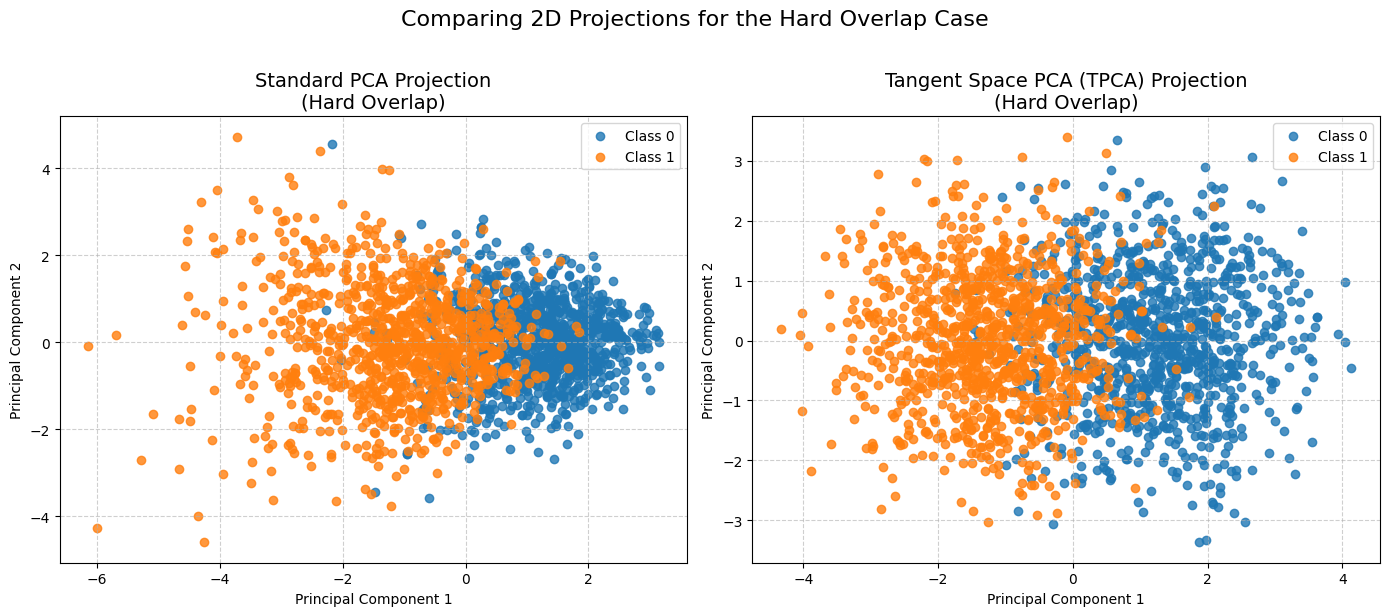


Visualization saved as 'pca_vs_tpca_hard_overlap.png'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geomstats.backend as gs
from geomstats.geometry.matrices import Matrices
from geomstats.geometry.general_linear import GeneralLinear
from geomstats.geometry.spd_matrices import SPDMatrices
from geomstats.learning.frechet_mean import FrechetMean

from scipy.linalg import expm, sqrtm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                DATA GENERATION (UNCHANGED)
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

def generate_spd_cluster(n_samples, n_dim, center_matrix, spread_bound):
    """Generates a cluster of SPD matrices around a specified center matrix."""
    size = (n_samples, n_dim, n_dim) if n_samples > 1 else (n_dim, n_dim)
    random_tangent_vectors_at_id = spread_bound * (
        2 * gs.random.rand(*size) - 1
    )
    random_tangent_vectors_at_id = Matrices.to_symmetric(
        random_tangent_vectors_at_id
    )
    points_at_id = GeneralLinear.exp(random_tangent_vectors_at_id)
    sqrt_center = sqrtm(center_matrix)
    cluster = gs.einsum('ij,...jk->...ik', sqrt_center, points_at_id)
    cluster = gs.einsum('...ij,jk->...ik', cluster, sqrt_center)
    return cluster

def generate_spd_data(n_samples_per_class, n_dim, separation, spread):
    """
    Generates a dataset with two SPD clusters with controllable overlap.
    """
    C1 = np.eye(n_dim)
    random_direction = Matrices.to_symmetric(np.random.randn(n_dim, n_dim))
    C2 = expm(separation * random_direction)
    cluster1 = generate_spd_cluster(n_samples_per_class, n_dim, C1, spread)
    cluster2 = generate_spd_cluster(n_samples_per_class, n_dim, C2, spread)
    X = gs.vstack([cluster1, cluster2])
    y = gs.hstack([
        gs.zeros(n_samples_per_class),
        gs.ones(n_samples_per_class)
    ])
    return X, y

# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                VISUALIZATION FUNCTION
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

def visualize_results(pca_data, tpca_data, labels, case_name):
    """
    Creates a side-by-side scatter plot of PCA and TPCA results.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    colors = ['#1f77b4', '#ff7f0e'] # Blue and Orange
    class_0_indices = np.where(labels == 0)
    class_1_indices = np.where(labels == 1)

    # Plot PCA results
    ax1.scatter(pca_data[class_0_indices, 0], pca_data[class_0_indices, 1],
                c=colors[0], label='Class 0', alpha=0.8)
    ax1.scatter(pca_data[class_1_indices, 0], pca_data[class_1_indices, 1],
                c=colors[1], label='Class 1', alpha=0.8)
    ax1.set_title(f'Standard PCA Projection\n({case_name})', fontsize=14)
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot TPCA results
    ax2.scatter(tpca_data[class_0_indices, 0], tpca_data[class_0_indices, 1],
                c=colors[0], label='Class 0', alpha=0.8)
    ax2.scatter(tpca_data[class_1_indices, 0], tpca_data[class_1_indices, 1],
                c=colors[1], label='Class 1', alpha=0.8)
    ax2.set_title(f'Tangent Space PCA (TPCA) Projection\n({case_name})', fontsize=14)
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    fig.suptitle(f'Comparing 2D Projections for the {case_name} Case', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f"pca_vs_tpca_{case_name.lower().replace(' ', '_')}.png")
    plt.show()

# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                      MAIN SCRIPT
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
if __name__ == '__main__':
    # --- Configuration for the visualization ---
    # We'll use the "Medium Overlap" case as it's the most illustrative
    CASE_NAME = "Hard Overlap"
    SEPARATION = 0.25
    SPREAD = 0.5
    N_SAMPLES = 2000
    N_DIM = 5
    REDUCED_DIM = 2 # We need 2D for plotting
    RANDOM_STATE = 42

    print(f"--- Generating data for visualization: {CASE_NAME} Case ---")
    X_spd, y_labels = generate_spd_data(
        n_samples_per_class=N_SAMPLES // 2, n_dim=N_DIM, separation=SEPARATION, spread=SPREAD
    )

    # --- Path A: Standard (Linear) PCA ---
    print("Running Standard PCA...")
    X_flat = X_spd[:, gs.triu_indices(N_DIM)[0], gs.triu_indices(N_DIM)[1]]
    pipeline_pca = Pipeline([
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=REDUCED_DIM))
    ])
    X_pca = pipeline_pca.fit_transform(X_flat)

    # --- Path B: Tangent Space (Geometric) PCA ---
    print("Running Tangent Space PCA...")
    spd_manifold = SPDMatrices(n=N_DIM)
    spd_metric = spd_manifold.metric
    mean_estimator = FrechetMean(space=spd_manifold)
    mean_estimator.fit(X_spd)
    riemannian_mean = mean_estimator.estimate_
    X_tan = spd_metric.log(X_spd, base_point=riemannian_mean)
    X_tan_flat = X_tan[:, gs.triu_indices(N_DIM)[0], gs.triu_indices(N_DIM)[1]]
    pipeline_tpca = Pipeline([
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=REDUCED_DIM))
    ])
    X_tpca = pipeline_tpca.fit_transform(X_tan_flat)

    # --- Generate the visualization ---
    print("Generating plot...")
    visualize_results(X_pca, X_tpca, y_labels, CASE_NAME)
    print(f"\nVisualization saved as 'pca_vs_tpca_{CASE_NAME.lower().replace(' ', '_')}.png'")